# "That's Unusual!"

## An Anomaly Detection System

Here, we implement an anomaly detection algorithm and use it to detect failing servers on a network.

In [99]:
# standard imports for any python ML project
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io

The following two cells import initial training and cross-validation data for use in constructing and testing our model. 

In [100]:
data = scipy.io.loadmat('data/ex8data1.mat')

In [101]:
X_train = data['X']
Xval = data['Xval']
yval = data['yval']

The features imported above measure the throughput (mb/s) and latency (ms) of the response of each server. While our servers were operating, we collected $m = 307$ examples of how they were behaving and, thus, created an unlabeled dataset $\{x^{(1)},\ldots,x^{(m)}\}$. We suspect that the vast majority of servers in our sample are acting normally, but there might also be servers acting anomalously within this dataset.

We will use a Gaussian model to detect anomalous examples in our dataset. We begin by examining the 2D dataset above, which will allow us to visualize what the algorithm is doing. On this dataset, we will 1) fit a Gaussian distribution and 2) find values that have very low probability of occurence. Servers with characteristics that have a low-probability of occurence are, by definition, anomalies. Once our exploration of our 2D data set is complete, we will apply the anomaly detection algorithm to a larger dataset with many dimensions.

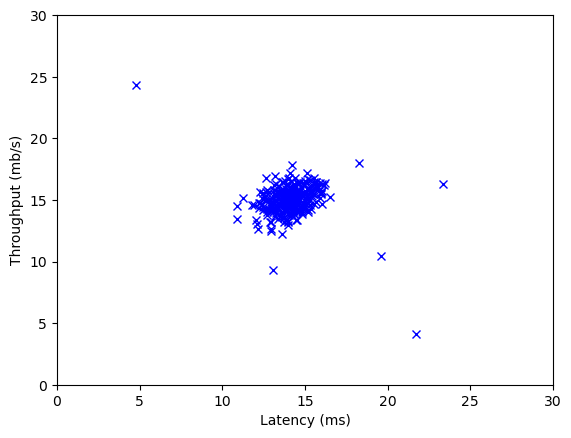

In [102]:
plt.plot(X_train[:, 0], X_train[:, 1], 'bx')
plt.axis([0, 30, 0, 30])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

From the plot above, it is evident that outliers (i.e., servers with unusual operating metrics) are present in our sample. 

To perform anomaly detection, we first must fit a model to the data's distribution. Given a training set $\{x^{(1)},\dots,x^{(m)}\}$ (where $x^{(i)}\in\mathbb{R}^n$), we want to estimate a Gaussian distribution for each of the features x_i. For each feature $i = 1\ldots n$, we need to find parameters $\mu_i$ and $\sigma^2_i$ that fit the data in the $i$-th dimension $\{x_i^{(1)},\ldots,x^{(m)}_i\}$ (the $i$-th dimension of each example).

The Gaussian distribution is given by $p(x;\mu,\sigma^2)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$ where $\mu$ is the mean and $\sigma^2$ is the variance. 

We can estimate the parameters,$(\mu_i,\sigma_i^2)$, of the $i$-th feature by using the following equations. To estimate the mean, we will use:
$\mu_i = \frac{1}{m}\sum_{j=1}^m{x^{(j)}}$ and for the variance we will use $\sigma^2_i = \frac{1}{m}\sum_{j=1}^m{(x^{(j)}-\mu_i)^2}$.


Our first task is to complete the helper function estimateGaussian.py. This will assist us in defining our Gaussian distribution. The function takes as input the data matrix $X$ and should output an $n$-dimensional vector, $\mu$, that holds the mean of all $n$ features and another $n$-dimensional vector, $var$, that holds the variances of all features. We use a vectorized implementation for the sake of efficiency.

In [103]:
def estimate_gaussian(X): 
    """
    Calculates mean and variance of all features 
    in the dataset
    
    Args:
        X (ndarray): (m, n) Data matrix
    
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """

    m, n = X.shape
    
    mu = np.sum(X, axis = 0) / m
    var = np.sum((X - mu)**2, axis = 0) / m
        
    return mu, var

mu, var = estimate_gaussian(X_train)

Using the formula above, we calculate the first two moments (i.e., the mean and variance) of our distribution, which we display in the following cell.

In [114]:
mu, var = estimate_gaussian(X_train)              

print("Mean of each feature:", mu)
print("Variance of each feature:", var)

Mean of each feature: [14.11222578 14.99771051]
Variance of each feature: [1.83263141 1.70974533]


While a numerical description of our distribution is sufficient, a visual aid to accompany our statistics seems appropriate. The following code creates our data visualization.

In [105]:
from scipy.stats import multivariate_normal
def multivariate_gaussian(X, mu, sigma2):
    """    
    Computes the probability density function of the examples X under the multivariate gaussian 
    distribution with parameters mu and sigma2. 
    If Sigma2 is a matrix, it is treated as the covariance matrix. 
    If Sigma2 is a vector, it is treated as the \sigma^2 values of the variances in each dimension (a diagonal
    covariance matrix)
    """
    p = multivariate_normal.pdf(X, mu, np.diag(sigma2))
    return p
p = multivariate_gaussian(X_train, mu, var)

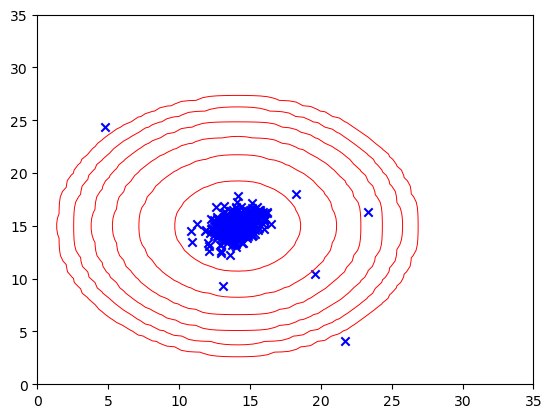

In [106]:
def visualize_fit(X_train, mu, Sigma2):
    """
    Visualize the fit of the multivariate Gaussian distribution.

    Parameters:
    - X: numpy array, dataset with each n-dimensional data point in one row
    - mu: numpy array, mean vector
    - Sigma2: numpy array, covariance matrix or vector of variances
    """
    plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', color='blue')
    x, y = np.meshgrid(np.linspace(0, 35, 70), np.linspace(0, 35, 70))
    points = np.column_stack((x.flatten(), y.flatten()))
    p = multivariate_gaussian(points, mu, Sigma2)
    p = p.reshape(x.shape)
    contour_levels = np.logspace(-20, 0, 7)
    plt.contour(x, y, p, levels=contour_levels, colors='red', linewidths=0.7)

visualize_fit(X_train, mu, var)

The plot confirms our intuition that most of our servers are located in a high-probability space.

Having estimated the Gaussian parameters, we can investigate which examples have a very high probability of occurence and which examples have a very low probability of occurence. The low- probability examples are most likely anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this section, we implement an algorithm to select the threshold $\epsilon$ using the $F_1$ score on a cross validation set.

We will use the `selectThreshold.py` function to assist us in sorting out high- and low- probability cases. For this, we will use a cross validation set, $\{(x^{(1)}_{cv},y^{(1)}_{cv}),\ldots, (x^{(m)}_{cv},y^{(m)}_{cv})\}$, where the label $y=1$ corresponds to an anomalous example, and $y=0$ corresponds to a normal example. For each cross validation example, we will compute $p(x^{(i)}_{cv})$. The vector of all of these probabilities $p(x^{(1)}_{cv}),\ldots,p(x^{(m)}_{cv})$ is passed to `selectThreshold.py` in the vector $pval$. The corresponding labels $y^{(1)}_{cv},\ldots,y^{(m)}_{cv}$ is passed to the same function in the vector $yval$.

The function `selectThreshold.py` should return two values; the first is the selected threshold $\epsilon$. If an example $x$ has a low probability $p(x) < \epsilon$, then it is considered to be an anomaly. The function should also return the $F_1$ score, which tells us how well we're doing with respect to finding the ground truth anomalies given a certain threshold. For many different values of $\epsilon$, we will compute the resulting $F_1$ score by computing how many examples the current threshold classifies correctly and incorrectly. The $F_1$ score is computed using precision (prec) and recall (rec): 

$F_1 = \frac{2 ( prec)(rec)}{prec + rec}$

We compute precision and recall by:
$prec = \frac{tp}{tp + fp}$, 
$rec = \frac{tp}{tp + fn}$ where $tp$ is the number of true positives (i.e., the ground truth label says it's an anomaly and our algorithm correctly classified it as an anomaly). $fp$ is the number of false positives (i.e., the ground truth label says it's not an anomaly, but our algorithm incorrectly classified it as an anomaly). $fn$ is the number of false negatives (i.e., the ground truth label says it's an anomaly, but our algorithm incorrectly classified it as not being anomalous).

In the code below, a loop will try many different values of $\epsilon$ and select the "best" based  on the $F_1$ score. The computation can be implemented using the $F_1$ score and a $for$ loop over all cross-validation examples to compute the values $tp$, $fp$, $fn$. We anticipate seeing a value for epsilon of about 8.99e-05.

In [1]:
def select_threshold(yval, pval):
    """
    Find the best threshold (epsilon) to use for selecting outliers.

    Parameters:
    - yval: numpy array, ground truth (0 for normal, 1 for outliers)
    - pval: numpy array, probability values from the validation set

    Returns:
    - best_epsilon: float, best threshold
    - best_F1: float, best F1 score
    """

    best_epsilon = 0
    best_F1 = 0
    F1 = 0

    step_size = (max(pval) - min(pval)) / 1000

    for epsilon in np.arange(min(pval), max(pval), step_size):
        
        predictions = (pval < epsilon).astype(int)

        tp = np.sum((predictions == 1) & (yval == 1))
        fp = np.sum((predictions == 1) & (yval == 0))
        fn = np.sum((predictions == 0) & (yval == 1))
        
        # precision and recall calculations
        prec = tp / (tp + fp) if (tp + fp) != 0 else 0
        rec = tp / (tp + fn) if (tp + fn) != 0 else 0

        F1 = (2 * prec * rec)/(prec + rec) if (prec + rec) != 0 else 0
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
            
    return best_epsilon, best_F1

As seen in the output below, our `selectThreshold` routine yielded the anticipated value for epsilon. 

In [108]:
p = multivariate_gaussian(Xval, mu, var)
epsilon, F1 = select_threshold(data['yval'].ravel(), p)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)

Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set: 0.875000


The code below circles outliers in red. As one can see, all but one of the circles are in the expected areas.

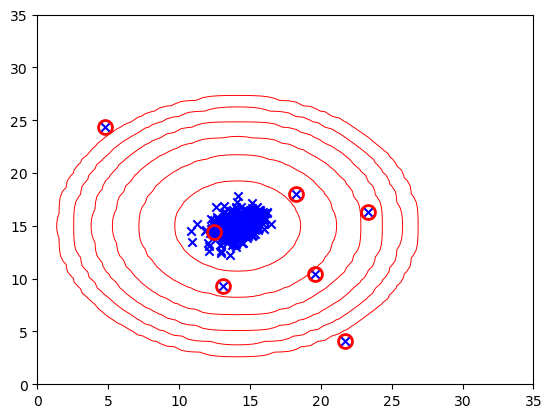

In [109]:
# Find the outliers in the training set 
outliers = np.argwhere(p < epsilon)
outliers = outliers.T[0]

# Visualize the fit
visualize_fit(X_train, mu, var)

# Draw a red circle around those outliers
plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro',
         markersize= 10,markerfacecolor='none', markeredgewidth=2)

The code in this section runs the anomaly detection algorithm on a more realistic and challenging dataset. Each observation in the dataset is described by 11 features, capturing many more server properties. The following code will use the routines written above to estimate the Gaussian parameters ($\mu_i$ and $\sigma^{2}_i$), evaluate the probabilities for both the training data $X$ from which we estimated the Gaussian parameters, and do so for the cross-validation set $Xval$. Finally, it will use `selectThreshold` to find the best threshold $\epsilon$ . We should see a value epsilon of about 1.38e-18, and 117 anomalies found.

In the following two cells, we load our data.

In [110]:
data = scipy.io.loadmat('data/ex8data2.mat')

In [111]:
X = data['X']
Xval = data['Xval']
yval = data['yval']

Below, we apply the algorithms developed during our exploration of a comparatively simple data set.

In [112]:
mu, var = estimate_gaussian(X)
p = multivariate_gaussian(X, mu, var)
pval = multivariate_gaussian(Xval, mu, var)
epsilon, f1 = select_threshold(yval.ravel(), pval)

The numbers displayed below indicate that our values for epsilon and total outliers came in as anticipated. This suggests our code is suitable for cases of varying complexity.

In [113]:
print('Best epsilon found using cross-validation:', epsilon)
print('Best F1 on Cross Validation Set:', f1)
print('# Outliers found: ', sum(p < epsilon))

Best epsilon found using cross-validation: 1.3772288907613604e-18
Best F1 on Cross Validation Set: 0.6153846153846154
# Outliers found:  117
